[Reference](https://medium.com/@rajsingh.tarun/backtesting-trading-strategies-with-chatgpt-in-python-a-step-by-step-guide-9dba0cb85610)

[*********************100%***********************]  1 of 1 completed
Total Return:  -0.0013904002903218915
Average Daily Return:  6.789486462859124e-05
Standard Deviation of Daily Return:  0.0013044651890856563
Maximum Drawdown:  0.02461830502978763


<ipython-input-1-51aa57ba37da>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)


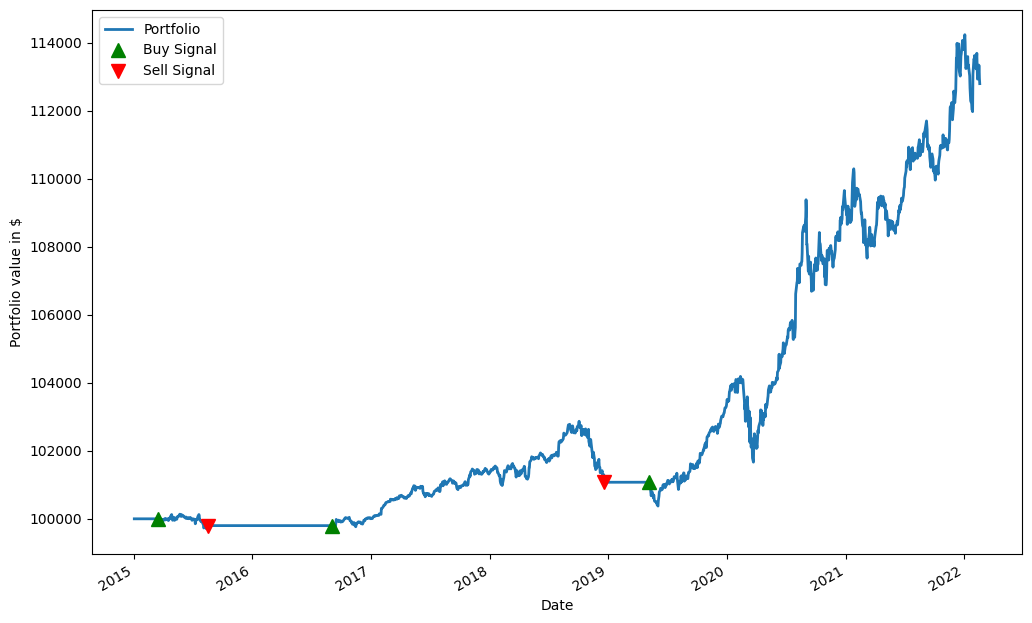

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Retrieve historical market data
data = yf.download('AAPL', start='2015-01-01', end='2022-02-22')

# Define trading strategy
def sma_crossover(data, short_window=50, long_window=200):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0
    signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1, center=False).mean()
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)
    signals['positions'] = signals['signal'].diff()

    return signals

# Backtest trading strategy
signals = sma_crossover(data)
initial_capital = float(100000.0)
positions = pd.DataFrame(index=signals.index).fillna(0.0)
positions['AAPL'] = 100 * signals['signal']
portfolio = positions.multiply(data['Adj Close'], axis=0)
pos_diff = positions.diff()
portfolio['holdings'] = (positions.multiply(data['Adj Close'], axis=0)).sum(axis=1)
portfolio['cash'] = initial_capital - (pos_diff.multiply(data['Adj Close'], axis=0)).sum(axis=1).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()

# Compute key performance metrics
print('Total Return: ', portfolio['returns'][-1])
print('Average Daily Return: ', portfolio['returns'].mean())
print('Standard Deviation of Daily Return: ', portfolio['returns'].std())
print('Maximum Drawdown: ', ((portfolio['total'].cummax() - portfolio['total']) / portfolio['total'].cummax()).max())

# Visualize backtesting results
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
portfolio['total'].plot(ax=ax1, lw=2.)
ax1.plot(portfolio.loc[signals.positions == 1.0].index, portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='g')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='r')
plt.legend(['Portfolio', 'Buy Signal', 'Sell Signal'])
plt.show()